# Topic Modeling

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd

from nltk.tokenize import sent_tokenize
from gensim.summarization import summarize, keywords, mz_keywords

import pickle

In [24]:
# Custom Topic Modeling Class
# Credit: Jacob Koehler

class SKTopics(BaseEstimator, TransformerMixin):
    def __init__(self, estimator = 'LDA', n_topics=20):
        self.n_topics = n_topics
        if estimator == 'LSA':
            self.estimator = TruncatedSVD(n_components=self.n_topics)
        elif estimator == 'NMF':
            self.estimator = NMF(n_components=self.n_topics)
        else:
            self.estimator = LatentDirichletAllocation(n_components=self.n_topics)
        self.model = make_pipeline(CountVectorizer(stop_words='english', max_features=200), 
                                   LatentDirichletAllocation(n_components=self.n_topics))
    
    def fit_transform(self, documents):
        self.model.fit_transform(documents)
        return self.model
    
    def get_topics(self, n = 25):
        vectorizer = self.model.named_steps['countvectorizer']
        model = self.model.steps[-1][1]
        names = vectorizer.get_feature_names()
        topics = dict()
        for idx, topic in enumerate(model.components_):
            features = topic.argsort()[:-(n-1): -1]
            tokens = [names[i] for i in features]
            topics[idx] = tokens
        return topics

In [25]:
with open('../data/episode_dialogues.pkl', 'rb') as f:
    episode_dialogues = pickle.load(f)

In [26]:
# Setting X
dialogue_list = [values for key, values in episode_dialogues.items()]
X = dialogue_list
X_summarized = [summarize(x, ratio=.05) for x in X]

In [27]:
# Instantiating model
sk = SKTopics(estimator = 'LDA', n_topics=20)

# Fitting 
sk.fit_transform(X_summarized)

# Getting topics
sk.get_topics(n=10)

{0: ['yeah', 'know', 'don', 'hey', 'oh', 'want', 'right', 'car'],
 1: ['know', 'don', 'like', 'just', 'oh', 'think', 'yeah', 'gonna'],
 2: ['try', 'kind', 'job', 'help', 'person', 'time', 'tickets', 'pick'],
 3: ['know', 'yeah', 'alright', 'think', 'hey', 'don', 'like', 'yes'],
 4: ['know', 'hey', 'yeah', 'like', 'oh', 'jerry', 'george', 'think'],
 5: ['car', 'yeah', 'hey', 'oh', 'don', 'right', 'know', 'got'],
 6: ['funny', 'yeah', 'oh', 'job', 'yes', 'hey', 'come', 'gonna'],
 7: ['try', 'kind', 'job', 'help', 'person', 'time', 'tickets', 'pick'],
 8: ['try', 'kind', 'job', 'help', 'person', 'time', 'tickets', 'pick'],
 9: ['dont', 'know', 'im', 'yeah', 'like', 'youre', 'right', 'just'],
 10: ['try', 'kind', 'job', 'help', 'person', 'time', 'tickets', 'pick'],
 11: ['big', 'know', 'oh', 'did', 'going', 'right', 'tell', 'george'],
 12: ['yeah', 'jerry', 'like', 'know', 'got', 'just', 'hey', 'oh'],
 13: ['hey', 'apartment', 'jerry', 'time', 'oh', 'going', 'tell', 'just'],
 14: ['try', '

**Getting Keywords from Gensim**

In [28]:
gensim_keywords = [keywords(i, ratio=.1, lemmatize=True, split=True) for i in X]

In [29]:
mz_keywords = [mz_keywords(i, split=True, weighted=False, threshold=1.2) for i in X]

/Users/alexander.fioto/opt/anaconda3/lib/python3.7/site-packages/gensim/summarization/mz_entropy.py:65: RuntimeWarning: divide by zero encountered in log2
  log_p = np.log2(p)
/Users/alexander.fioto/opt/anaconda3/lib/python3.7/site-packages/gensim/summarization/mz_entropy.py:66: RuntimeWarning: invalid value encountered in multiply
  h = np.nan_to_num(p * log_p).sum(axis=0)


In [30]:
mz_keywords[58]

['mint',
 'now',
 'commit',
 'wood',
 'c',
 'george',
 'mon',
 'adultery',
 'bank',
 'better',
 'bye',
 'clara',
 'patient',
 'retractor',
 'weight',
 'will',
 'yep',
 'operation',
 'ask',
 'couldn',
 'doctor',
 'dunno',
 'falls',
 'fun',
 'ha',
 'lose',
 'lost',
 'lot',
 'luck',
 'meet',
 'more',
 'over',
 'second',
 'whole',
 'wittenberg']

**Extracting Keywords Using BERT**

In [3]:
from sentence_transformers import SentenceTransformer

In [32]:
with open('../data/episode_dialogues.pkl', 'rb') as f:
    episodes = pickle.load(f)

In [33]:
doc = sent_tokenize(episodes['S01E01'])

In [34]:
ngram_range = (2,2)
stop_words = 'english'

count = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range).fit(doc)
candidates = count.get_feature_names()


In [35]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
doc_embedding = model.encode([doc[0]])
candidate_embeddings = model.encode(candidates)

In [36]:
distances = cosine_similarity(doc_embedding, candidate_embeddings)

In [39]:
top_n = 10
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

In [40]:
keywords

['whats',
 'did',
 'happened',
 'does',
 'contact',
 'reason',
 'experience',
 'matters',
 'interpretation',
 'whatd']

**Topic Modeling with BERT**

In [41]:
df = pd.read_csv('../data/scripts.csv', index_col=0)
df.dropna(inplace=True)

In [42]:
seinfeld_dialogue = list(df['Dialogue'])

In [43]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(seinfeld_dialogue, show_progress_bar=True)

In [44]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [45]:
import hdbscan

import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

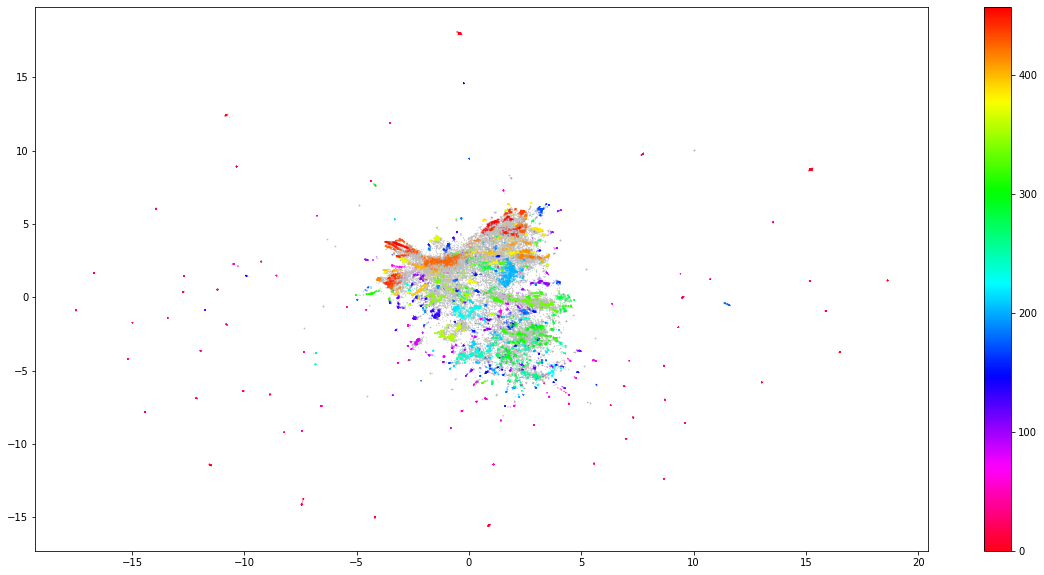

In [46]:

import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar();

In [47]:
docs_df = pd.DataFrame(seinfeld_dialogue, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})


In [48]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(seinfeld_dialogue))

/Users/alexander.fioto/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [49]:

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,30242
203,202,945
427,426,698
1,0,419
4,3,419
132,131,236
10,9,218
305,304,212
357,356,200
438,437,200


In [50]:
top_n_words[300][:10]

[('know', 0.9270789624633146),
 ('yeah', 0.8040515648077777),
 ('understand', 0.672886396501018),
 ('yap', 0.3095379353104687),
 ('oh', 0.23475915805854655),
 ('yes', 0.12035019121125337),
 ('tell', 0.11841104804636911),
 ('right', 0.09506829732352223),
 ('firmly', 0.0),
 ('firstborn', 0.0)]

In [51]:
top_n_words[322][:10]

[('gonna', 0.1507508012920109),
 ('years', 0.10776077412479129),
 ('night', 0.09973215707052825),
 ('know', 0.09105239809907553),
 ('shame', 0.07562644371774419),
 ('like', 0.07562426729410812),
 ('entire', 0.07060117346164424),
 ('months', 0.07060117346164424),
 ('weekend', 0.06780835886493974),
 ('yesterday', 0.06633856937286894)]

In [1]:

for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)